In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors
pal = ['#009473','#00537c', '#b4b4b4', '#da3e21']
cmap = matplotlib.colors.ListedColormap(pal)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score
import sklearn.cluster as cluster
import time
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(42)

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
df.shape

(2240, 29)

In [4]:
df = df.rename(columns={'MntWines':'wines', 'MntFruits':'fruits', 'MntMeatProducts':'meat', 'MntFishProducts':'fish', 'MntSweetProducts':'sweet', 'MntGoldProds':'gold'})


In [6]:
numeric_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in df.columns if col not in numeric_columns]
bool_columns = [col for col in df.columns if df[col].dtype == 'bool']
date_columns = [col for col in df.columns if df[col].dtype == 'datetime64[ns]']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   wines                2240 non-null   int64  
 10  fruits               2240 non-null   int64  
 11  meat                 2240 non-null   int64  
 12  fish                 2240 non-null   int64  
 13  sweet                2240 non-null   int64  
 14  gold                 2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [8]:
df.isna().sum()

,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
wines,0


In [10]:
income_missing = df[df['Income'].isnull()]

In [11]:
group_means = df.groupby('Education')['Income'].mean()

In [12]:
df['Income'] = df['Income'].fillna(df['Education'].map(group_means))

In [13]:
group_means

,Income
Education,
2n Cycle,47633.190000
Basic,20306.259259
Graduation,52720.373656
Master,52917.534247
PhD,56145.313929


In [15]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y')

In [16]:
max_date = df['Dt_Customer'].max()
min_date = df['Dt_Customer'].min()

pd.Timestamp('now')

Timestamp('2025-10-08 15:40:23.837034')

In [17]:
df['Days_since_enrolment'] = df['Dt_Customer'].apply(lambda x: (pd.Timestamp('now') - x).days)

In [18]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,wines,fruits,meat,fish,sweet,gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_since_enrolment
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,4782
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,4232
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,4431
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,4258
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,4280


In [20]:
df['Age'] = pd.Timestamp('now').year - df['Year_Birth']

In [21]:
df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [22]:
df['Marital_Status'] = df['Marital_Status'].apply(lambda x: 'Partnered' if x in ['Married', 'Together'] else 'Single')

In [23]:
df['Children'] = df['Kidhome'] + df['Teenhome']

In [24]:
df['Family_Size'] = df['Children'] + df['Marital_Status'].replace({'Partnered':2, 'Single':1})

In [25]:
df['Is_Parent'] = np.where(df['Children'] > 0, 1, 0)

In [26]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,wines,fruits,meat,fish,sweet,gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_since_enrolment,Age,Children,Family_Size,Is_Parent
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,4782,68,0,1,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,4232,71,2,3,1
2,4141,1965,Graduation,Partnered,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,4431,60,0,2,0
3,6182,1984,Graduation,Partnered,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,4258,41,1,3,1
4,5324,1981,PhD,Partnered,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,4280,44,1,3,1


In [27]:
df['Spent'] = df['wines'] + df['fruits'] + df['meat'] + df['fish'] + df['sweet'] + df['gold']

In [28]:
df.drop(columns = ['Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID'], inplace = True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2240 non-null   object 
 1   Marital_Status        2240 non-null   object 
 2   Income                2240 non-null   float64
 3   Kidhome               2240 non-null   int64  
 4   Teenhome              2240 non-null   int64  
 5   Recency               2240 non-null   int64  
 6   wines                 2240 non-null   int64  
 7   fruits                2240 non-null   int64  
 8   meat                  2240 non-null   int64  
 9   fish                  2240 non-null   int64  
 10  sweet                 2240 non-null   int64  
 11  gold                  2240 non-null   int64  
 12  NumDealsPurchases     2240 non-null   int64  
 13  NumWebPurchases       2240 non-null   int64  
 14  NumCatalogPurchases   2240 non-null   int64  
 15  NumStorePurchases    

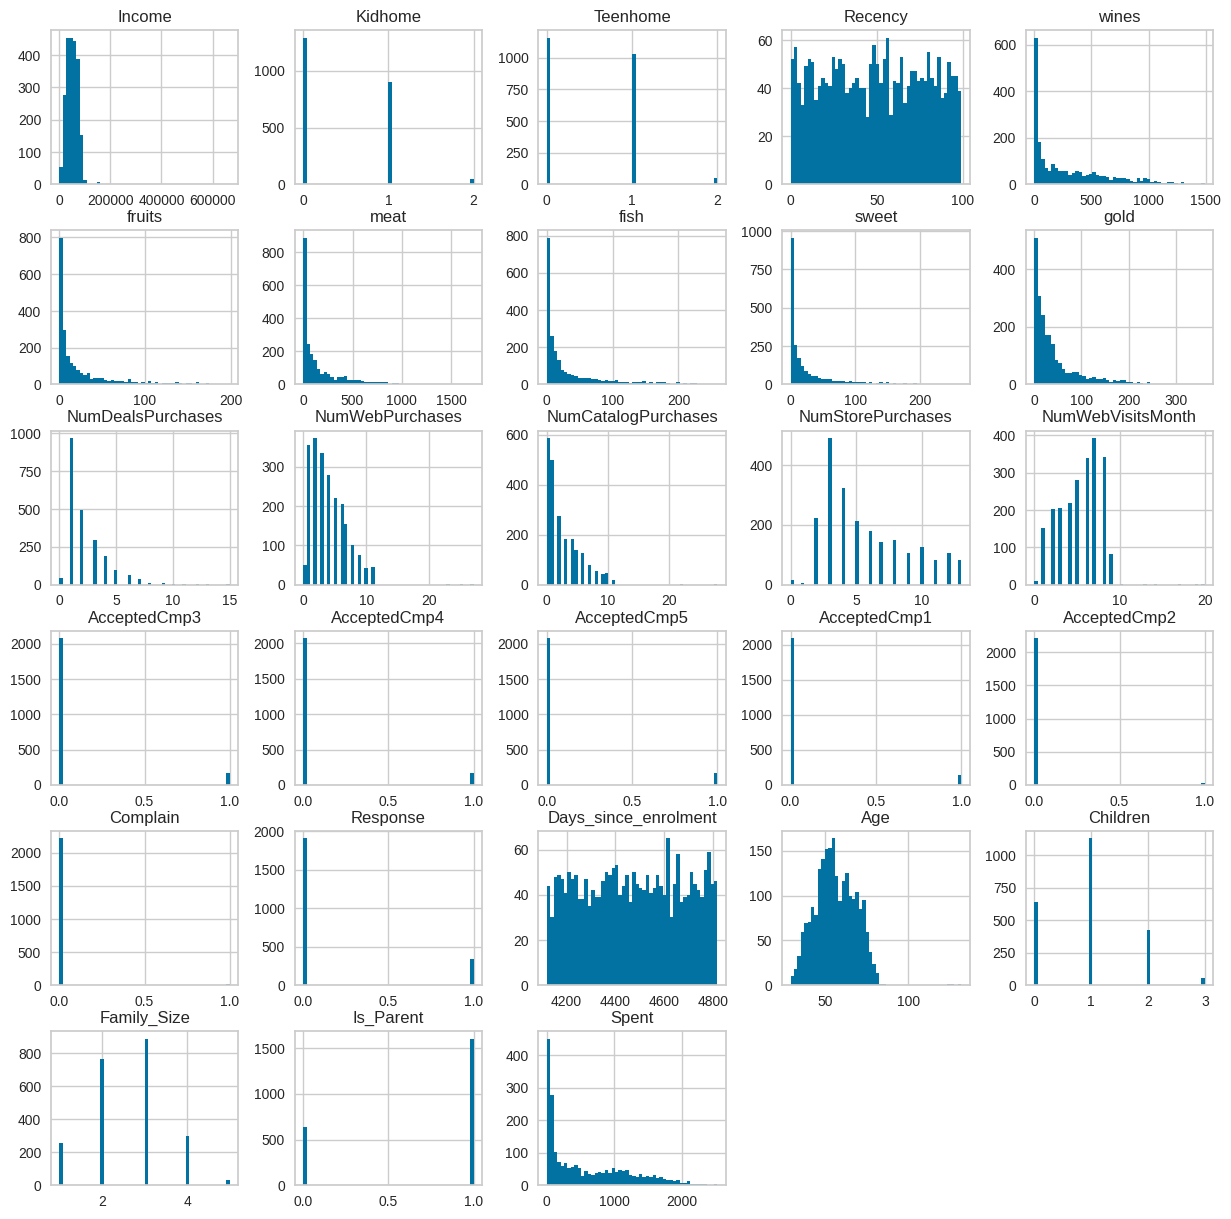

In [30]:
df.hist(figsize=(15,15), bins=50);
plt.show()

In [31]:
df = df[df['Age'] < 90]

In [32]:
df[df['Income'] < 300000].shape

(2236, 30)

In [33]:
df = df[df['Income'] < 200000]

In [34]:
df.shape

(2236, 30)

<Axes: >

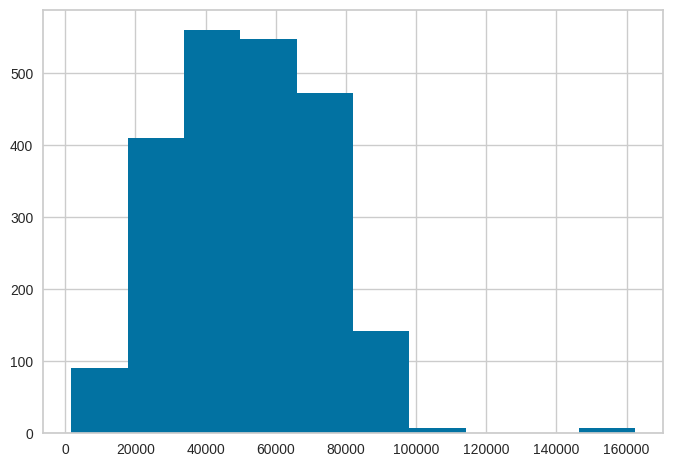

In [35]:
df['Income'].hist()

<Axes: >

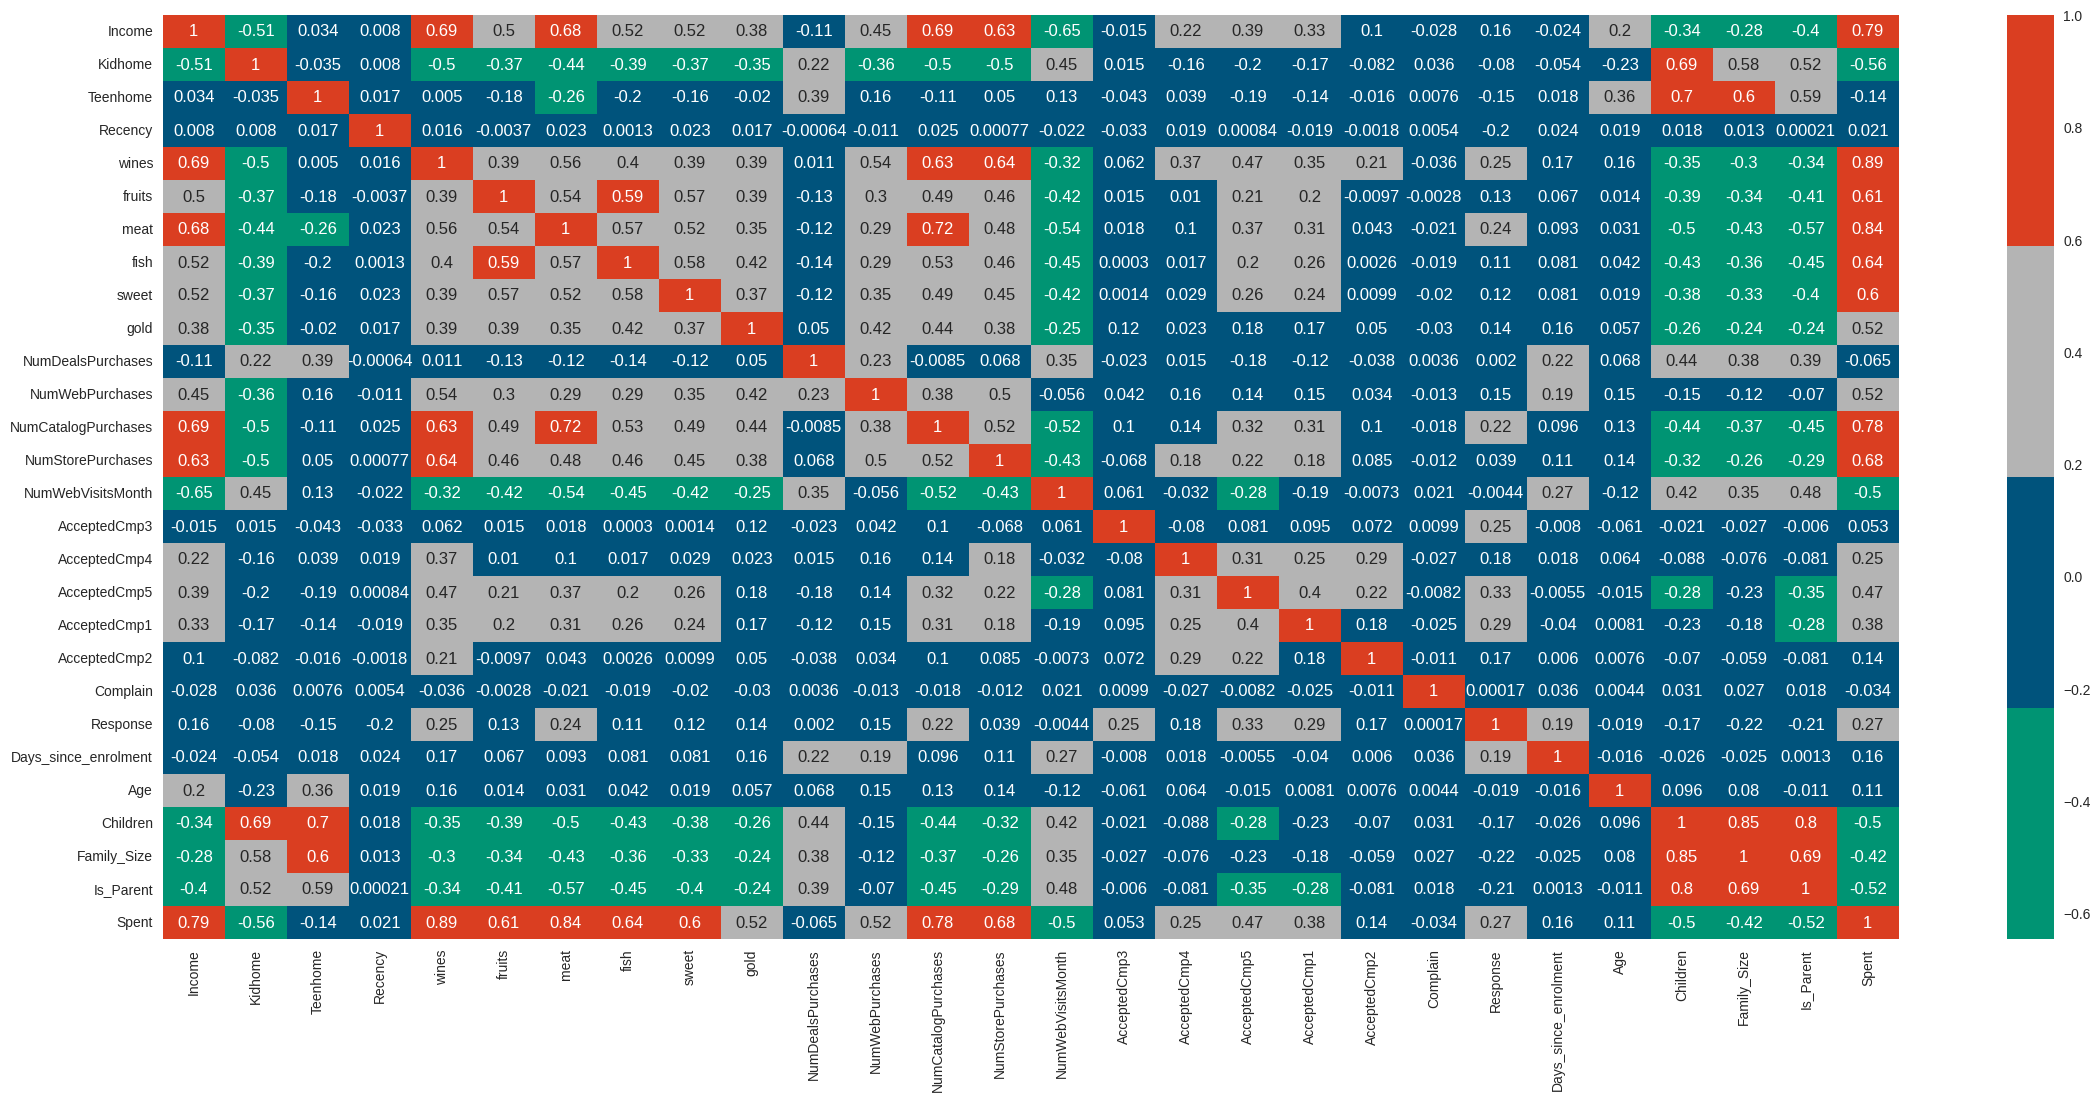

In [37]:
plt.figure(figsize = (28, 12))
sns.heatmap(df.select_dtypes(include = [np.number]).corr(), annot=True, cmap = cmap)

In [38]:
oe = OrdinalEncoder()

df['Education'] = oe.fit_transform(df[['Education']])
df['Marital_Status'] = oe.fit_transform(df[['Marital_Status']])

In [39]:
sc = StandardScaler()

df_scaled = sc.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns = df.columns)

In [40]:
df_scaled.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,wines,fruits,meat,fish,sweet,gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_since_enrolment,Age,Children,Family_Size,Is_Parent,Spent
0,-0.352133,1.347635,0.288195,-0.824939,-0.930615,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,0.348738,1.407639,2.509801,-0.552429,0.692865,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,2.386338,1.529793,1.016868,-1.264308,-1.758810,-1.584362,1.680176
1,-0.352133,1.347635,-0.262715,1.032627,0.905974,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,-0.168700,-1.110921,-0.568970,-1.167738,-0.131421,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,-0.419052,-1.191143,1.273264,1.395139,0.445618,0.631169,-0.962202
2,-0.352133,-0.742041,0.917627,-0.824939,-0.930615,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,-0.686137,1.407639,-0.226884,1.293496,-0.543564,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,-0.419052,-0.206659,0.333146,-1.264308,-0.656596,-1.584362,0.282541
3,-0.352133,-0.742041,-1.182829,1.032627,-0.930615,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,-0.168700,-0.751127,-0.911056,-0.552429,0.280722,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,-0.419052,-1.062517,-1.290693,0.065416,0.445618,0.631169,-0.918994
4,1.429245,-0.742041,0.295435,1.032627,-0.930615,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,1.383614,0.328256,0.115201,0.062879,-0.131421,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,-0.419052,-0.953679,-1.034298,0.065416,0.445618,0.631169,-0.305762


In [41]:
df_scaled.shape

(2236, 30)

In [42]:
pca = PCA()

df_pca = pca.fit(df_scaled)

In [44]:
pca.explained_variance_ratio_

array([0.29091309, 0.09897713, 0.06438386, 0.05551505, 0.04782199,
       0.04033211, 0.03517217, 0.03360462, 0.03340895, 0.03295562,
       0.02814305, 0.02581659, 0.02214943, 0.02155202, 0.02026807,
       0.01919677, 0.01810385, 0.01698072, 0.01483155, 0.0144557 ,
       0.01369443, 0.01245546, 0.01034244, 0.00901491, 0.0073029 ,
       0.00664302, 0.0059645 , 0.        , 0.        , 0.        ])

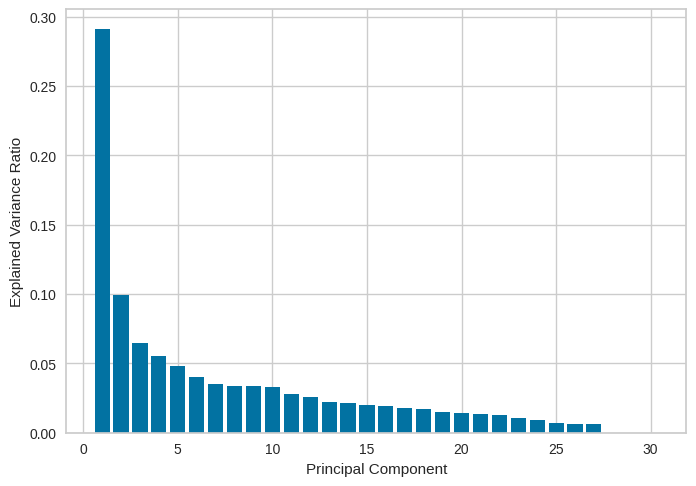

In [45]:
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [46]:
print('Percentage of cumulative variance of PCs: ', pca.explained_variance_ratio_.cumsum()*100)

Percentage of cumulative variance of PCs:  [ 29.09130916  38.98902168  45.42740792  50.97891326  55.76111259
  59.79432407  63.31154104  66.67200278  70.01289759  73.30845983
  76.12276465  78.70442351  80.91936643  83.07456848  85.10137564
  87.02105263  88.83143755  90.52950921  92.01266426  93.45823435
  94.82767782  96.07322368  97.10746799  98.00895866  98.73924832
  99.40354984 100.         100.         100.         100.        ]


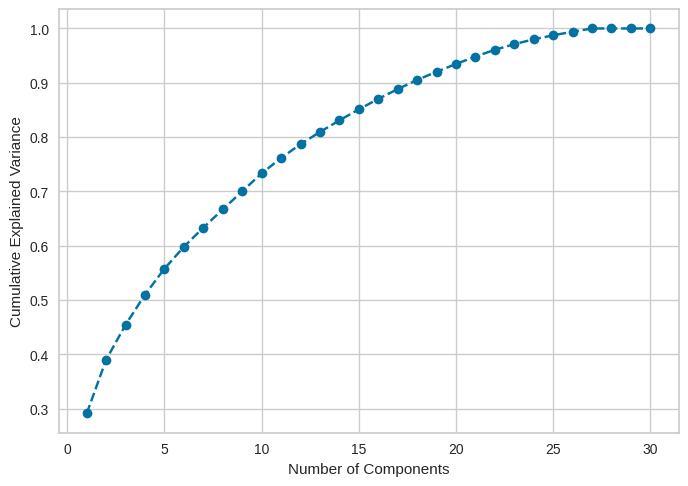

In [48]:
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_), marker = 'o', linestyle = '--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [49]:
pca = PCA(n_components = 3)

pca.fit(df_scaled)

df_pca = pca.transform(df_scaled)

df_pca = pd.DataFrame(df_pca, columns = ['PC1', 'PC2', 'PC3'])

In [50]:
df_pca.head()

,PC1,PC2,PC3
0,4.906168,-0.382186,0.103166
1,-2.951464,-0.038895,-0.302930
2,2.345955,-0.841817,-1.173358
3,-2.732009,-1.552536,-0.007231
4,-0.756445,0.325581,-0.635205


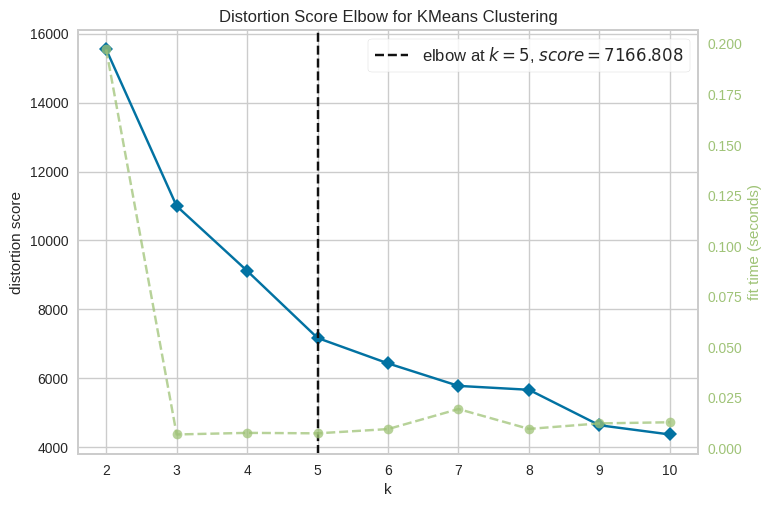

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
# Elbow Method

Elbow = KElbowVisualizer(KMeans(), k = 10)
Elbow.fit(df_pca)
Elbow.show()

In [52]:
#Kmeans cu df_pca

In [ ]:
# df['clusters'] = kmeans.cluster_centers_

In [ ]:
# cluster1 = df[df['clusters'] == 0]
# cluster2 = df[df['clusters'] == 1]
# cluster3 = df[df['clusters'] == 2]
# cluster4 = df[df['clusters'] == 3]
# cluster5 = df[df['clusters'] == 4]